# Autoencoder

Autohenodery to sieci neuronowe zdolne do uczenia się wydajnych reprezentacji danych wejściowych, nazywanymi **codings** kodami, bez żadnego nadzoru. Te kody mają zazwyczaj znacznie mniejszą wymiarowość niż dane wejściowe, dzięki czemu autoenodemy są przydatne do redukcji wymiarów. 

Co ważniejsze, autoenodemy pełnią funkcję detektorów cech i mogą być używane jako ekstraktory cech (feature detectors) w głębokich sieciach neuronowe. 

Wreszcie są w stanie generować nowe dane, które wyglądają bardzo podobnie do danych uczących (nazywa się to modelem generatywnym). Możesz na przykład nauczyć autocenoder na zdjęciach twarzy, a następnie generować nowe twarze.


## Data Representations


Autoenoder zawsze składa się z dwóch części: 

  * enkodera, który konwertuje wejścia do nowej (wewnętrznwj) reprezentacji,
  * dekodera (lub sieci generatywna), który konwertuje wewnętrzną reprezentację na wyjścia.
  
Jak widać, autoenoderer zazwyczaj ma taką samą architekturę jak Perceptron wielowarstwowy (MLP), z tym że liczba neuronów w warstwie wyjściowej musi być równa liczbie wejść. 

W poniższym przykładzie istnieje tylko jedna ukryta warstwa złożona z dwóch neuronów (kodera) i jedna warstwa wyjściowa złożona z trzech neuronów (dekoder). Wyjścia są często nazywane **reconstructions** (rekonstrukcjami), ponieważ autoenoder próbuje zrekonstruować wejścia, a funkcja kosztu zawiera **reconstruction loss** (niedoskonałość rekonstrukcji), która karze model, gdy rekonstrukcje różnią się od wejść.  

## Wykonywanie PCA za pomocą autoenodera

Jeśli autoenoder wykorzystuje tylko aktywacje liniowe, a funkcja kosztu to błąd średniej kwadratowej (MSE), wówczas otrzymujemy PCA. Poniższy kod tworzy prosty liniowy autoencoder, aby wykonać PCA na zestawie danych 3D, wyświetlając go w 2D:

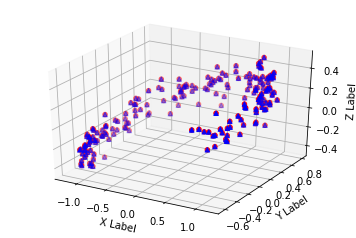

In [1]:
import numpy as np
import numpy.random as rnd


rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
    xs = data[:, 0]
    ys = data[:, 1]
    zs = data[:, 2]
    ax.scatter(xs, ys, zs, c=c, marker=m)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

In [3]:
import tensorflow as tf

tf.reset_default_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)



In [4]:
init = tf.global_variables_initializer()

n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

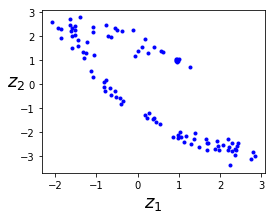

In [5]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

Ten kod nie różni się bardzo od MLP, które zbudowaliśmy na poprzednich zajęciach. Dwie rzeczy do zapamiętania to:
  
  * Liczba wyjść jest równa liczbie wejść.
  * Aby wykonać prosty PCA, ustawiamy activation_fn = None (tj. Wszystkie neurony są liniowe), a funkcją kosztu jest MSE.

# Zadanie

Dla danych iris wykonaj redukcję wymiarowości za pomocą autoencodera.
Następnie naucz SVM (użyj rbf z optymalnymi parametrami) na 
  * danych oryginalnych 
  * danych po redukcji
oraz porównaj wyniki za pomocą miary F1.


## Deep autoenkoder

Podobnie jak inne sieci neuronowe, o których mówiliśmy, autoenkodery mogą mieć wiele ukrytych warstw. W tym przypadku są one nazywane **deep autoenkoder** lub **stacked autoencoders**. 

Dodanie kolejnych warstw pomaga autoenkoderowi uzyskać bardziej złożone kodowanie. Należy jednak uważać, aby nie spowodować, aby autoenkoder był zbyt mocny. Wyobraź sobie enkoder tak potężny, że uczy się mapować każde wejście na jedną dowolną liczbę (a dekoder uczy odwrotnego mapowania). Oczywiście taki autoenkoder idealnie zrekonstruuje dane treningowe, ale nie nauczy się żadnej użytecznej reprezentacji danych (i jest mało prawdopodobne, aby generalizować dobrze nowe instancje).

Architektura głębokich autoenkoderó jest zwykle symetryczna w odniesieniu do centralnej ukrytej warstwy (warstwy kodującej). 

Na przykład, autoenoder do danych MNIST może mieć 784 neuronów wejścia, następnie ukryta warstwa z 300 neuronami, następnie centralna ukryta warstwa z 150 neuronów, następnie kolejna ukryta warstwa z 300 neuronami i warstwa wyjściowa z 784 neuronami. 

In [6]:
from functools import partial
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() 

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
import os
import sys
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") 
            sys.stdout.flush()                                          
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   
        print("\r{}".format(epoch), "Train MSE:", loss_train)           
        saver.save(sess, "./my_model_all_layers.ckpt")                  

0 Train MSE: 0.0241241
1 Train MSE: 0.0143475
2 Train MSE: 0.0115198
39% Train MSE: 0.0106679
4 Train MSE: 0.0111002


In [12]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys")
    plt.axis("off")

def show_reconstructed_digits(X, outputs, model_path = None, n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(4, 2 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])
        plt.show()

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


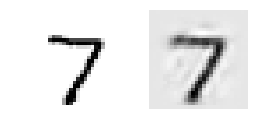

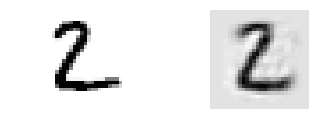

In [13]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")

# Zadanie 
wykonaj analogiczne zadanie na danych:
  
  *  CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html)
  *  CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

# DODATKOWE MATERIAŁY NIE OBOWIĄZUJĄ NA ZAJĘCIA:

# Wspólne wagi
Powszechne jest powiązanie wag enkodera i dekodera (**tie the
weights**)
```pythin
weights_decoder = tf.transpose #(weights_encoder). 
```
Niestety uniemożliwia to (lub bardzo trudne) korzystanie z funkcji tf.layers.dense (), dlatego musimy ręcznie zbudować Autentoder:

In [14]:
tf.reset_default_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [17]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # tied weights
weights4 = tf.transpose(weights1, name="weights4")  # tied weights

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [18]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")
        

09% Train MSE: 0.0156176
1 Train MSE: 0.0169
2 Train MSE: 0.0162351
3 Train MSE: 0.0174748
4 Train MSE: 0.0163433


INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


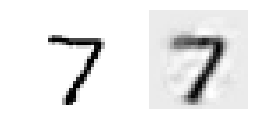

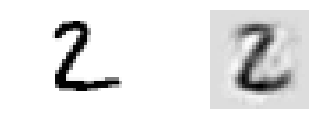

In [19]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

# Visualizing the extracted features

INFO:tensorflow:Restoring parameters from ./my_model_tying_weights.ckpt


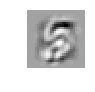

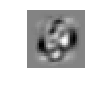

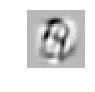

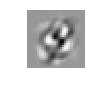

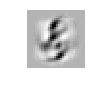

In [25]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_tying_weights.ckpt") # not shown in the book
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])
    plt.show()

# Variational Autoencoders

Kolejna ważna kategoria autododerów są: wariacyjnych autoencoder **Variational Autoencoders**.

Różnią się one od klasycznych autoencoder, które omówiliśmy do tej pory, w szczególności:

  * Są to probabilistyczne autoencodery, co oznacza, że ich wyniki są częściowo losowe.
  * Co najważniejsze, są to generatywne autoencoder, co oznacza, że mogą generować nowe instancje, które wyglądają, jakby zostały pobrane z zestawu treningowego.


Rzućmy okiem na to, jak działają Variational Autoencoders. Rysunek poniżej (jego lewa część) pokazuje Variational Autoencoders. Można oczywiście rozpoznać podstawową strukturę wszystkich autoencoderów, z enkoderem, po którym następuje dekoder (w tym przykładzie oba mają dwie ukryte warstwy), ale jest pewna różnica: zamiast bezpośredniego tworzenia kodu dla danego wejścia , koder wytwarza średnią $\mu$ i odchylenie standardowe $\sigma$. Rzeczywiste kodowanie jest następnie losowo próbkowane z rozkładu Gaussa ze średnią $\mu$ i odchyleniem standardowym $\sigma$. Następnie dekoder dekoduje normalnie kodowane próbkowanie. 

Prawa część diagramu pokazuje proces jaki przechdzą dane wejściowe przechodzące przez autoencoder. Najpierw enkoder wytwarza $\mu$ i $\sigma$, następnie losowo próbkowane jest kodowanie (zauważ, że nie jest ono dokładnie umiejscowione w $\mu$), i ostatecznie to kodowanie jest dekodowane, a końcowe wyjście przypomina instancję wejściową.

In [28]:
tf.reset_default_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [29]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [30]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [32]:
n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        saver.save(sess, "./my_model_variational.ckpt")
        
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})        

0 Train total loss: 32746.6 	Reconstruction loss: 25510.1 	Latent loss: 7236.46
1 Train total loss: 31675.7 	Reconstruction loss: 24646.4 	Latent loss: 7029.33
2 Train total loss: 29557.2 	Reconstruction loss: 23823.3 	Latent loss: 5733.91
3 Train total loss: 33851.4 	Reconstruction loss: 23110.3 	Latent loss: 10741.0
49% Train total loss: 29369.5 	Reconstruction loss: 22338.2 	Latent loss: 7031.32
5 Train total loss: 25718.9 	Reconstruction loss: 20606.4 	Latent loss: 5112.5
6 Train total loss: 22332.5 	Reconstruction loss: 18348.3 	Latent loss: 3984.17
79% Train total loss: 19716.4 	Reconstruction loss: 17200.7 	Latent loss: 2515.66
8 Train total loss: 21018.8 	Reconstruction loss: 18426.3 	Latent loss: 2592.54
9 Train total loss: 18013.3 	Reconstruction loss: 15188.7 	Latent loss: 2824.61
10 Train total loss: 17630.9 	Reconstruction loss: 14809.0 	Latent loss: 2821.93
11 Train total loss: 16495.0 	Reconstruction loss: 13445.6 	Latent loss: 3049.48
12 Train total loss: 16092.9 	Recon

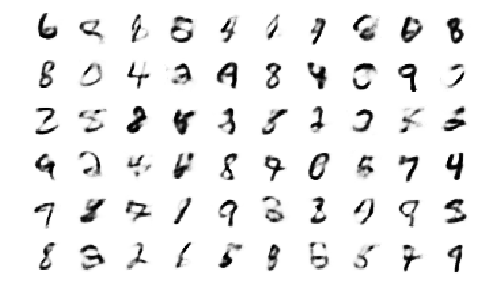

In [36]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])
plt.show()    

Encode:

In [38]:
n_digits = 3
X_test, y_test = mnist.test.next_batch(batch_size)
codings = hidden3

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    codings_val = codings.eval(feed_dict={X: X_test})
codings_val    

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


array([[-1.00631809,  1.00514603,  0.5527128 , ..., -0.94988191,
        -0.78910124,  1.39771891],
       [-1.75698602, -0.17039676, -0.09801798, ...,  0.67574167,
         1.57178569,  0.04219674],
       [-0.60036105, -1.69885647,  0.49717575, ...,  0.20000625,
         1.15720117, -0.31664121],
       ..., 
       [-1.43397856,  0.5825184 ,  1.14524865, ..., -0.08096059,
        -1.26139462,  0.67215645],
       [ 0.00766761,  0.24184054,  1.10127509, ..., -2.04808712,
        -0.0264989 ,  0.11008649],
       [-0.81928182,  0.66107601,  0.53990704, ..., -0.80889815,
         0.55440068, -0.72229016]], dtype=float32)

Decode:

In [39]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    outputs_val = outputs.eval(feed_dict={codings: codings_val})
outputs_val    

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


array([[  1.86175275e-09,   8.53004681e-11,   5.66287550e-09, ...,
          3.46486145e-10,   9.79887171e-10,   2.53139905e-11],
       [  1.71267670e-11,   3.79059666e-11,   1.43995345e-11, ...,
          5.62124444e-11,   1.71254608e-11,   1.01768566e-10],
       [  2.75222040e-10,   6.95978475e-09,   1.94220751e-09, ...,
          4.08508893e-10,   2.24139751e-09,   1.54450441e-09],
       ..., 
       [  1.41836951e-08,   5.05740072e-09,   1.91026732e-08, ...,
          2.25722498e-08,   9.36720426e-08,   2.73916196e-08],
       [  2.25480989e-09,   4.58060978e-10,   1.64687908e-08, ...,
          2.35092301e-09,   1.25600852e-09,   1.18540811e-09],
       [  6.59718902e-09,   2.34341204e-08,   5.18193755e-09, ...,
          1.12038612e-09,   1.29112250e-08,   1.67437375e-09]], dtype=float32)

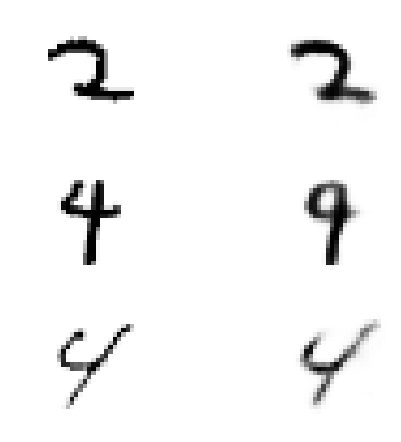

In [40]:
fig = plt.figure(figsize=(8, 2.5 * n_digits))
for iteration in range(n_digits):
    plt.subplot(n_digits, 2, 1 + 2 * iteration)
    plot_image(X_test[iteration])
    plt.subplot(n_digits, 2, 2 + 2 * iteration)
    plot_image(outputs_val[iteration])
plt.show()

# Interpolate digits

INFO:tensorflow:Restoring parameters from ./my_model_variational.ckpt


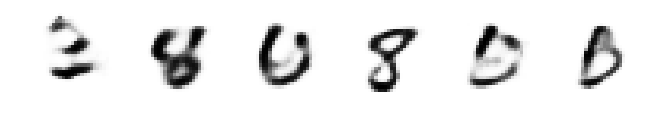

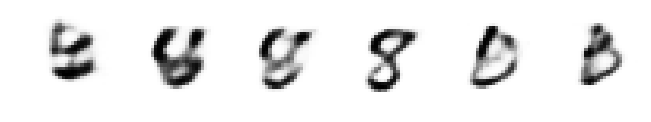

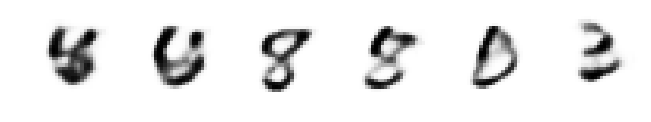

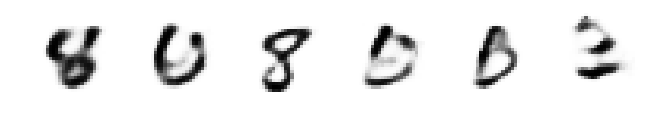

In [44]:
n_iterations = 3
n_digits = 6
codings_rnd = np.random.normal(size=[n_digits, n_hidden3])

with tf.Session() as sess:
    saver.restore(sess, "./my_model_variational.ckpt")
    target_codings = np.roll(codings_rnd, -1, axis=0)
    for iteration in range(n_iterations + 1):
        codings_interpolate = codings_rnd + (target_codings - codings_rnd) * iteration / n_iterations
        outputs_val = outputs.eval(feed_dict={codings: codings_interpolate})
        plt.figure(figsize=(11, 1.5*n_iterations))
        for digit_index in range(n_digits):
            plt.subplot(1, n_digits, digit_index + 1)
            plot_image(outputs_val[digit_index])
        plt.show()